## Step 0: Set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.sparse import hstack

In [2]:
# Reproducibility 
SEED = 42

# Horizon used when we created the label in preprocessing 
H = 3

In [3]:
# Where preprocessing saved the split CSVs
DATA_PROCESSED_DIR = "data/processed"

# Where will store outputs from this model
OUT_PRED_DIR = "outputs/predictions"
OUT_FIG_DIR = "outputs/figures"

# Create output folders if they don't exist
os.makedirs(OUT_PRED_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

## Step 1: Load the preprocessed splits and define features

We load `train/val/test` daily CSVs produced by `preprocessing.py`, then define the exact feature columns we’ll use.


In [5]:
# Load the preprocessed daily splits 
train_path = os.path.join(DATA_PROCESSED_DIR, f"train_daily_H{H}.csv")
val_path   = os.path.join(DATA_PROCESSED_DIR, f"val_daily_H{H}.csv")
test_path  = os.path.join(DATA_PROCESSED_DIR, f"test_daily_H{H}.csv")

train_df = pd.read_csv(train_path, parse_dates=["date"])
val_df   = pd.read_csv(val_path, parse_dates=["date"])
test_df  = pd.read_csv(test_path, parse_dates=["date"])

print("Rows (train/val/test):", len(train_df), len(val_df), len(test_df))

Rows (train/val/test): 1214 270 256


In [6]:
# Features
feature_cols = [
    "sent_mean", "sent_std", "n_tweets",
    "sent_mean_lag1", "sent_std_lag1", "n_tweets_lag1",
    "ret", "ret_lag1"
]


In [7]:
# Targets + ticker ids
y_train = train_df["y"].to_numpy(dtype=int)
y_val   = val_df["y"].to_numpy(dtype=int)
y_test  = test_df["y"].to_numpy(dtype=int)

tid_train = train_df["ticker_id"].to_numpy(dtype=int)
tid_val   = val_df["ticker_id"].to_numpy(dtype=int)
tid_test  = test_df["ticker_id"].to_numpy(dtype=int)

print("Feature count:", len(feature_cols))

Feature count: 8


## Step 2: Scale numeric features, one-hot encode ticker and build X matrices

We scale the numeric features using train-only statistics, one-hot encode `ticker_id`, and concatenate both into the final feature matrices.
Scaling helps the optimizer, and one-hot enables logreg to assoicate information to its ticker.


In [8]:
# Scale numeric features 
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

X_train_num = scaler.transform(train_df[feature_cols])
X_val_num   = scaler.transform(val_df[feature_cols])
X_test_num  = scaler.transform(test_df[feature_cols])

# 2) One-hot encode ticker_id 
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
ohe.fit(tid_train.reshape(-1, 1))

X_train_ticker = ohe.transform(tid_train.reshape(-1, 1))
X_val_ticker   = ohe.transform(tid_val.reshape(-1, 1))
X_test_ticker  = ohe.transform(tid_test.reshape(-1, 1))

# Concatenate: [scaled numeric with one-hot ticker]
#    We keep it sparse because the one-hot part is mostly zeros
X_train = hstack([X_train_num, X_train_ticker]).tocsr()
X_val   = hstack([X_val_num, X_val_ticker]).tocsr()
X_test  = hstack([X_test_num, X_test_ticker]).tocsr()

print("X shapes:", X_train.shape, X_val.shape, X_test.shape)

X shapes: (1214, 14) (270, 14) (256, 14)


## Step 3: Train logistic regression

We try a few regularization strengths (`C`) and keep the one with the best validation accuracy.
This should give us a fair baseline without overfitting to the test set.


In [9]:
C_grid = [0.01, 0.1, 1.0, 10.0]

best_model = None
best_C = None
best_val_acc = -1.0

for C in C_grid:
    # Logistic regression classifier
    clf = LogisticRegression(
        C=C,
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        random_state=SEED
    )

    # Train on train split
    clf.fit(X_train, y_train)

    # Validate on val split
    val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"C={C:<5} | val_acc={val_acc:.3f}")

    # Keep best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C
        best_model = clf

print("Best C:", best_C, "| Best val acc:", round(best_val_acc, 3))


C=0.01  | val_acc=0.493
C=0.1   | val_acc=0.511
C=1.0   | val_acc=0.541
C=10.0  | val_acc=0.541
Best C: 1.0 | Best val acc: 0.541


In [10]:
coef = best_model.coef_.ravel()[:len(feature_cols)]

feat_importance = (
    pd.DataFrame({"feature": feature_cols, "coef": coef, "abs_coef": np.abs(coef)})
      .sort_values("abs_coef", ascending=False)
)

print(feat_importance)

          feature      coef  abs_coef
0       sent_mean  0.072216  0.072216
5   n_tweets_lag1  0.069585  0.069585
6             ret -0.046291  0.046291
4   sent_std_lag1 -0.025361  0.025361
2        n_tweets -0.022539  0.022539
1        sent_std  0.012640  0.012640
7        ret_lag1  0.012384  0.012384
3  sent_mean_lag1 -0.008494  0.008494


Based on the coefficient table, sent_mean_lag1 is almost zero (so it adds very little), and ret_lag1 is also very small. We decide  to drop sent_mean_lag1 and ret_lag1, and keep the rest (sent_mean, n_tweets_lag1, ret, sent_std_lag1, n_tweets, sent_std). That way we keep the features that seem to carry the most signal, we reduce noise and redundancy, and we make the pipeline easier to explain. 

After this, we just re-run training and confirm validation performance is the same (or better); if it stays stable, we stick with the reduced feature set for the final comparison across models.

## Step 4: Drop weak features and retrain

Wee remove the two weakest features (`sent_mean_lag1`, `ret_lag1`), rebuild the design matrices, and retrain logistic regression.
Those features had almost zero coefficients, so simplifying should reduce noise without hurting validation performance.


In [14]:
# Updated feature list 
feature_cols = [
    "sent_mean", "sent_std", "n_tweets",
    "sent_std_lag1", "n_tweets_lag1",
    "ret"
]

print("Using reduced feature set:", feature_cols)

# Rebuild numeric matrices 
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

X_train_num = scaler.transform(train_df[feature_cols])
X_val_num   = scaler.transform(val_df[feature_cols])
X_test_num  = scaler.transform(test_df[feature_cols])

# Rebuild ticker one-hot 
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
ohe.fit(tid_train.reshape(-1, 1))

X_train_ticker = ohe.transform(tid_train.reshape(-1, 1))
X_val_ticker   = ohe.transform(tid_val.reshape(-1, 1))
X_test_ticker  = ohe.transform(tid_test.reshape(-1, 1))

Using reduced feature set: ['sent_mean', 'sent_std', 'n_tweets', 'sent_std_lag1', 'n_tweets_lag1', 'ret']


In [15]:
# Final sparse matrices
X_train = hstack([X_train_num, X_train_ticker]).tocsr()
X_val   = hstack([X_val_num, X_val_ticker]).tocsr()
X_test  = hstack([X_test_num, X_test_ticker]).tocsr()

print("X shapes:", X_train.shape, X_val.shape, X_test.shape)


X shapes: (1214, 12) (270, 12) (256, 12)


In [16]:
C_grid = [0.01, 0.1, 1.0, 10.0]

best_model = None
best_C = None
best_val_acc = -1.0

for C in C_grid:
    clf = LogisticRegression(
        C=C,
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        random_state=SEED
    )
    clf.fit(X_train, y_train)

    val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"[Reduced] C={C:<5} | val_acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C
        best_model = clf

print("Best C (reduced):", best_C, "| Best val acc (reduced):", round(best_val_acc, 3))


[Reduced] C=0.01  | val_acc=0.481
[Reduced] C=0.1   | val_acc=0.522
[Reduced] C=1.0   | val_acc=0.533
[Reduced] C=10.0  | val_acc=0.533
Best C (reduced): 1.0 | Best val acc (reduced): 0.533


We tried simplifying the logistic regression by removing the features that looked weakest in the coefficient table, but validation accuracy dropped slightly (from ~0.541 to ~0.533). Even if those coefficients were small, they still seem to add a bit of useful information when combined with the other variables. So, for the final baseline and for a fair comparison with the other models, we keep the full feature set. This keeps performance as strong as possible and avoids accidentally removing small signals that help the model in practice.

## Step 5: Final test evaluation + save predictions + save plots

We evaluate the chosen model on the test set, save confusion matrix + ROC plot, and export a CSV with probabilities/predictions.


In [17]:
# Test predictions + probabilities
test_pred = best_model.predict(X_test)
test_proba_up = best_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, test_pred)
print("Test accuracy:", round(float(test_acc), 3))

Test accuracy: 0.527


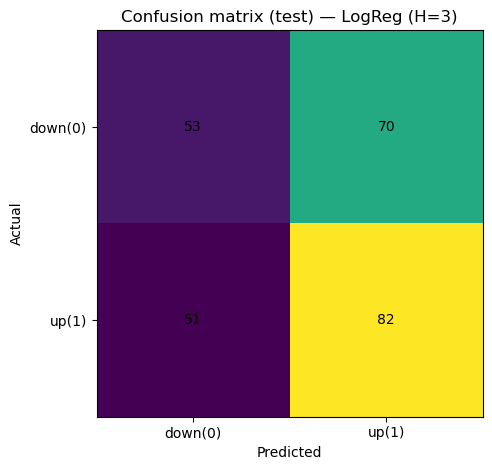

Saved: outputs/figures/logreg_confusion_H3.png


In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)

plt.figure()
plt.imshow(cm)
plt.title(f"Confusion matrix (test) — LogReg (H={H})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["down(0)", "up(1)"])
plt.yticks([0, 1], ["down(0)", "up(1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()

cm_path = os.path.join(OUT_FIG_DIR, f"logreg_confusion_H{H}.png")
plt.savefig(cm_path)
plt.show()
print("Saved:", cm_path)


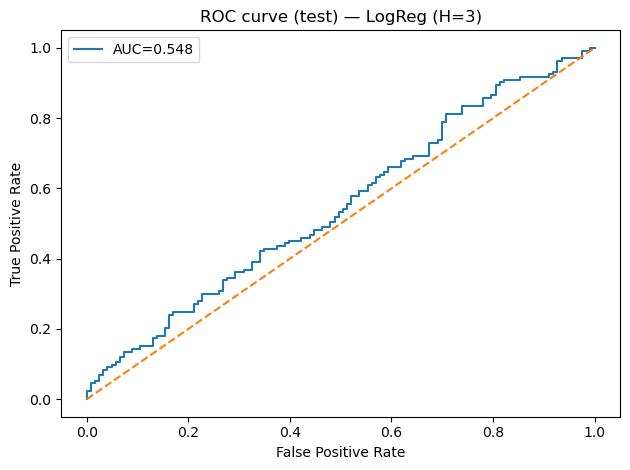

Saved: outputs/figures/logreg_roc_H3.png
Test AUC: 0.548


In [19]:
# ROC + AUC 
auc = roc_auc_score(y_test, test_proba_up)
fpr, tpr, _ = roc_curve(y_test, test_proba_up)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC curve (test) — LogReg (H={H})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()

roc_path = os.path.join(OUT_FIG_DIR, f"logreg_roc_H{H}.png")
plt.savefig(roc_path)
plt.show()
print("Saved:", roc_path)

print("Test AUC:", round(float(auc), 3))


From the confusion matrix, the model is doing a bit better than random, but it’s not very strong. It correctly predicts 53 downs and 82 ups, and it makes mistakes in both directions (it predicts up when it was actually down 70 times, and predicts down when it was actually up 51 times). Overall, it seems slightly biased toward predicting up more often (because the “predicted up” column is larger).
The ROC curve confirms the same story: the AUC is 0.548, which is only a little above 0.5 (random guessing). So the logistic regression baseline is capturing some weak signal from sentiment/volume/returns, but the separation between up vs down is limited. This is fine as a baseline: now we can check if MLP/CNN/LSTM actually improves on it.

In [20]:
# Save predictions table 
preds = test_df[["date", "ticker_id"]].copy()
preds["proba_up"] = test_proba_up
preds["pred_up"] = test_pred
preds["actual_up"] = y_test
preds["correct"] = (preds["pred_up"] == preds["actual_up"]).astype(int)

preds = preds.sort_values(["date", "ticker_id"]).reset_index(drop=True)

out_csv = os.path.join(OUT_PRED_DIR, f"logreg_predictions_H{H}.csv")
preds.to_csv(out_csv, index=False)
print("Saved:", out_csv)

preds.head()


Saved: outputs/predictions/logreg_predictions_H3.csv


,date,ticker_id,proba_up,pred_up,actual_up,correct
0,2023-11-05,1,0.567015,1,0,0
1,2023-11-05,2,0.411166,0,1,0
2,2023-11-06,0,0.559495,1,1,1
3,2023-11-06,1,0.542309,1,0,0
4,2023-11-06,2,0.403494,0,1,0
